# Steps involved in making recommendation system:
* Importing neccessary libraries
* Data collection
* Data importing
* Data cleaning and preprocessing
* Data analysis and visualization
* Machine learning model implementation
    1. Content-based filtering
    2. Collaborative filtering
* Model evaluation
* Hyperparameter tuning and model evaluation again

Dataset used:
For this project i am using the movielens small dataset: https://grouplens.org/datasets/movielens/latest/


In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# this is required to make the plot appear inside the notebook


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import mean_squared_error

# from sklearn.model_selection import train_test_split
from wordcloud import WordCloud


# importing surprise library
from surprise.model_selection import train_test_split

from surprise import NormalPredictor, Reader
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import Dataset, dump
from surprise import accuracy
from surprise.model_selection import cross_validate, GridSearchCV

import pickle

import warnings; warnings.simplefilter('ignore')

Description of the tmdb dataset
credits dataset:
* movie_id - A unique identifier for each movie.
* cast - The name of lead and supporting actors.
* crew - The name of Director, Editor, Composer, Writer etc.

movies dataset:
* budget - The budget in which the movie was made.
* genre - The genre of the movie, Action, Comedy ,Thriller etc.
* homepage - A link to the homepage of the movie.
id - This is infact the movie_id as in the first dataset.
* keywords - The keywords or tags related to the movie.
* original_language - The language in which the movie was made.
* original_title - The title of the movie before translation or adaptation.
* overview - A brief description of the movie.
* popularity - A numeric quantity specifying the movie popularity.
* production_companies - The production house of the movie.
* production_countries - The country in which it was produced.
* release_date - The date on which it was released.
* revenue - The worldwide revenue generated by the movie.
* runtime - The running time of the movie in minutes.
* status - "Released" or "Rumored".
* tagline - Movie's tagline.
* title - Title of the movie.
* vote_average - average ratings the movie recieved.
* vote_count - the count of votes recieved.

In [47]:
# df1=pd.read_csv('TMDB Dataset/tmdb_5000_movies.csv')
# df2=pd.read_csv('TMDB Dataset/tmdb_5000_credits.csv')

In [48]:
# df1.head()

In [49]:
# df2.head()

# movie lens dataset

In [50]:
linksdf=pd.read_csv('Movielens dataset/links.csv')
tagsdf=pd.read_csv('Movielens dataset/tags.csv')
moviesdf=pd.read_csv('Movielens dataset/movies.csv')
ratingsdf=pd.read_csv('Movielens dataset/ratings.csv')

In [51]:
linksdf.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [52]:
tagsdf.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [53]:
moviesdf.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [54]:
ratingsdf.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Merging the dataset and analysing as one dataset

In [55]:
movies_rating_df = pd.merge(moviesdf, ratingsdf, on='movieId')

In [56]:
movies_rating_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [57]:
movies_rating_df.shape

(100836, 6)

In [58]:
movies_rating_df.columns


Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

In [59]:
movies_rating_df.isna().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [60]:
# Analysing the insights of the data
movies_rating_df.describe()

,movieId,userId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,19435.295718,326.127564,3.501557,1.205946e+09
std,35530.987199,182.618491,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,1199.000000,177.000000,3.000000,1.019124e+09
50%,2991.000000,325.000000,3.500000,1.186087e+09
75%,8122.000000,477.000000,4.000000,1.435994e+09
max,193609.000000,610.000000,5.000000,1.537799e+09


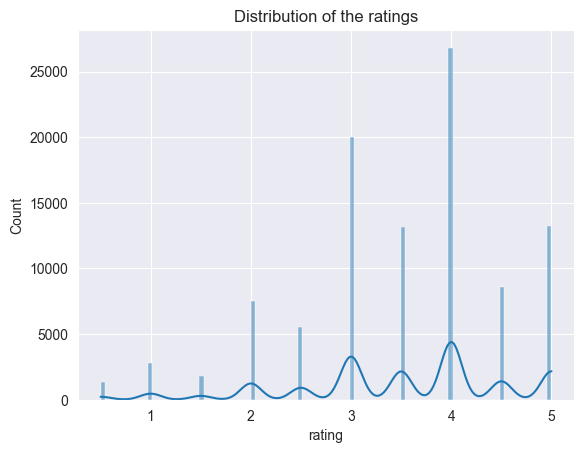

In [61]:
# Data distribution of ratings
sns.histplot(movies_rating_df['rating'], kde=True)
plt.title('Distribution of the ratings')
plt.show()

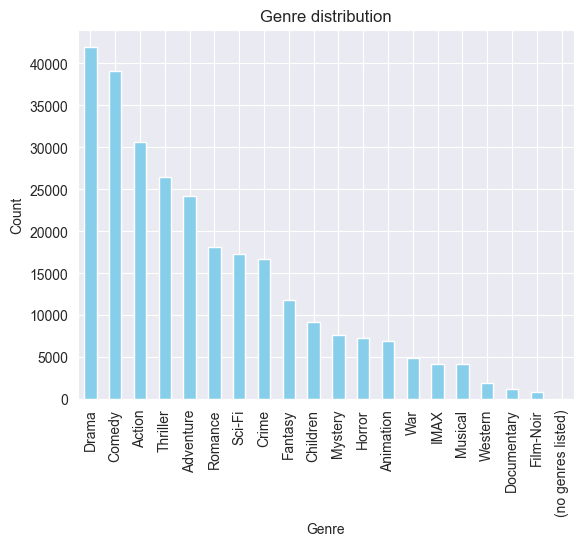

In [62]:
# Genre Analysis
genre_counts=movies_rating_df['genres'].str.split('|', expand=True).stack().value_counts()
genre_counts.plot(kind='bar', color='skyblue')
plt.title("Genre distribution")
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

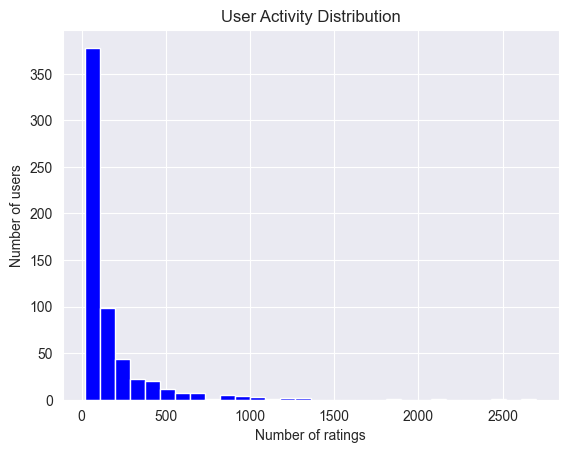

In [63]:
# user activity analysis
# visualising the number of ratings per user
user_activity=movies_rating_df['userId'].value_counts()
user_activity.plot(kind='hist', bins=30, color='blue')
plt.title('User Activity Distribution')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()

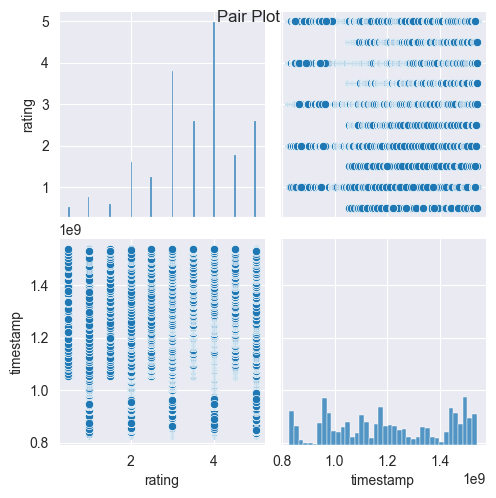

In [64]:
# Ploting pair plot to visualise the realtionship between ratings and timestamp
sns.pairplot(movies_rating_df[['rating', 'timestamp']])
plt.suptitle('Pair Plot')
plt.show()

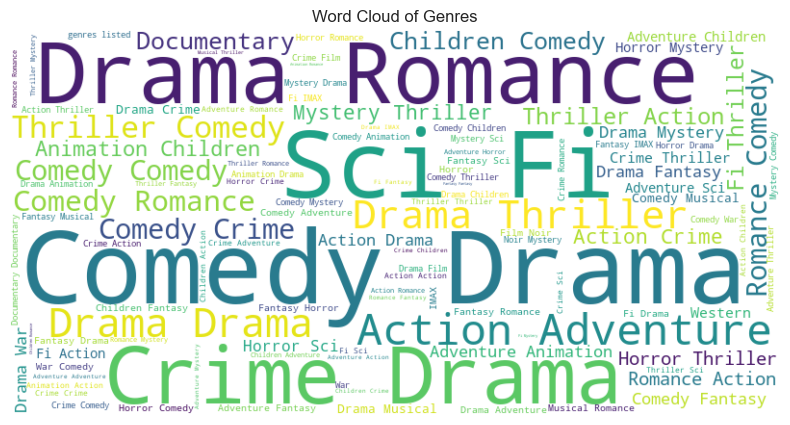

In [65]:
# Plotting a word cloud to find the most common genre in the dataset
genres_text = ' '.join(moviesdf['genres'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(genres_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Genres')
plt.show()

In [66]:
genres_text

'Adventure|Animation|Children|Comedy|Fantasy Adventure|Children|Fantasy Comedy|Romance Comedy|Drama|Romance Comedy Action|Crime|Thriller Comedy|Romance Adventure|Children Action Action|Adventure|Thriller Comedy|Drama|Romance Comedy|Horror Adventure|Animation|Children Drama Action|Adventure|Romance Crime|Drama Drama|Romance Comedy Comedy Action|Comedy|Crime|Drama|Thriller Comedy|Crime|Thriller Crime|Drama|Horror|Mystery|Thriller Action|Crime|Thriller Drama|Sci-Fi Drama|Romance Drama Children|Drama Drama|Romance Adventure|Drama|Fantasy|Mystery|Sci-Fi Crime|Drama Drama Mystery|Sci-Fi|Thriller Children|Drama Crime|Drama Children|Comedy Comedy|Romance Drama Drama|War Action|Crime|Drama Drama Action|Adventure|Fantasy Comedy|Drama|Thriller Drama|Romance Mystery|Thriller Animation|Children|Drama|Musical|Romance Drama|Romance Crime|Mystery|Thriller Comedy|Drama|Romance Adventure|Drama Children|Comedy Drama Drama Comedy|Drama|Romance Adventure|Children|Fantasy Drama|Thriller Drama Comedy|Crime C

# Now creating a content-based recommendation system

# creating a TF-IDF Vectorizer
TF-IDF: Stands for term frequency-inverse document frequency and it a measure, It converts the fraw documents to a matrix of TF-IDF features

In [67]:
tfidf_vectorizer=TfidfVectorizer(stop_words='english')

In [68]:
# Fill the missing values and create a TF-IDF matrix
# Preprocess genres to create a single string for each movie
tfidf_matrix=tfidf_vectorizer.fit_transform(moviesdf['genres'])



In [69]:
moviesdf['genres'].value_counts()


genres
Drama                                                  1053
Comedy                                                  946
Comedy|Drama                                            435
Comedy|Romance                                          363
Drama|Romance                                           349
                                                       ... 
Action|Crime|Horror|Mystery|Thriller                      1
Adventure|Animation|Children|Comedy|Musical|Romance       1
Action|Adventure|Animation|Comedy|Crime|Mystery           1
Children|Comedy|Fantasy|Sci-Fi                            1
Action|Animation|Comedy|Fantasy                           1
Name: count, Length: 951, dtype: int64

In [70]:
ratingsdf.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [71]:
# Function for content-based recommendation system
def content_based_recommendation(movie_title, tfidf_matrix, movies_ratings_df):
    try:
        movie_index = movies_ratings_df[movies_ratings_df['title'] == movie_title].index[0]
    except IndexError:
        print(f"Movie with title '{movie_title}' not found in the dataset.")
        return []

    # calculate the cosine similarities between input movies and other movies
    cosine_similarities=linear_kernel(tfidf_matrix[movie_index], tfidf_matrix).flatten()

    # get the indices of movies most similar to input movie
    similar_movie_indices=cosine_similarities.argsort()[:-11:-1] # getting the top 10 similar movies

    # return the title of the recommended movies
    recommended_movies=movies_ratings_df['title'].iloc[similar_movie_indices].tolist()

    similarity_scores = cosine_similarities[similar_movie_indices].tolist()

    return recommended_movies, similarity_scores



In [72]:
# testing the content-based recommender system
user_input='Iron Man (2008)'
recommended_movies,similarity=content_based_recommendation(user_input, tfidf_matrix, moviesdf)
print(f"Recommended movies for {user_input}:")
for movie, score in zip(recommended_movies, similarity):
    print(f"{movie}: Similarity Score = {score}")

Recommended movies for Iron Man (2008):
Valerian and the City of a Thousand Planets (2017): Similarity Score = 1.0
Black Panther (2017): Similarity Score = 1.0
X-Men: Days of Future Past (2014): Similarity Score = 1.0
Returner (Ritaanaa) (2002): Similarity Score = 1.0
Transformers: Age of Extinction (2014): Similarity Score = 1.0
Waterworld (1995): Similarity Score = 1.0
20,000 Leagues Under the Sea (1916): Similarity Score = 1.0
Guardians of the Galaxy (2014): Similarity Score = 1.0
Power Rangers (2017): Similarity Score = 1.0
Jupiter Ascending (2015): Similarity Score = 1.0


In [73]:
moviesdf.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [74]:
len(movies_rating_df['title'].value_counts())

9719

# Implementing recommendation system using collaborative filtering using KNNBasics

In [75]:
ratingsdf.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [76]:
reader=Reader(rating_scale=(1,5))

In [77]:
data=Dataset.load_from_df(ratingsdf[['userId','movieId','rating']], reader)

In [78]:
data.raw_ratings[:5]

[(1, 1, 4.0, None),
 (1, 3, 4.0, None),
 (1, 6, 4.0, None),
 (1, 47, 5.0, None),
 (1, 50, 5.0, None)]

In [79]:
user_ids_in_data = set([uid for uid, _, _, _ in data.raw_ratings])


In [80]:
user_ids_in_data

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [81]:
# splitting the dataset into train and test set
trainset, testset=train_test_split(data, test_size=0.25, random_state=42)

In [82]:
# algo=SVD()
# create a KNNBAsic collaborative filtering model: user-based
model=KNNBasic(sim_option={'user_based':True})

In [83]:
model.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [84]:
predictions=model.test(testset)

In [85]:
mse=accuracy.mse(predictions)
rmse=accuracy.rmse(predictions)

MSE: 0.9144
RMSE: 0.9562


In [110]:
benchmark = []

# Iterate over all algorithms
algorithms = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

print("Attempting:", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting:", str(algorithm))
    # Perform cross-validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MSE', 'MAE'], cv=5, verbose=False)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    algorithm_name = algorithm.__class__.__name__
    tmp = pd.concat([tmp, pd.Series([algorithm_name], name='Algorithm')])
    benchmark.append(tmp)
    print("Done:", str(algorithm), "\n\n")

print('\n\tDONE\n')


Attempting: [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000001AFFB296C10>, <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x000001AFEFADD650>, <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x000001AFEF8621D0>, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x000001AFF1F65690>, <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x000001AFF00BB890>, <surprise.prediction_algorithms.knns.KNNBaseline object at 0x000001AFFB6EC750>, <surprise.prediction_algorithms.knns.KNNBasic object at 0x000001AFF0135510>, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x000001AFFB6EFE90>, <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x000001AFFB96C690>, <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x000001AFF0090CD0>, <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x000001AFECF4BC90>] 



Starting: <surprise.prediction_algorithms.ma

In [111]:
results=pd.DataFrame(benchmark)
results

,test_rmse,test_mse,test_mae,fit_time,test_time,0
0,0.874512,0.764778,0.672662,0.789125,0.074916,SVD
1,0.861336,0.741917,0.659457,42.500828,8.367953,SVDpp
2,0.899744,0.809556,0.688084,2.502416,4.212718,SlopeOne
3,0.919381,0.845325,0.703999,1.733040,0.062396,NMF
4,1.417255,2.008617,1.131061,0.087083,0.047077,NormalPredictor
5,0.874593,0.764926,0.668080,0.317967,1.045671,KNNBaseline
6,0.945753,0.894479,0.725596,0.151042,0.791459,KNNBasic
7,0.895571,0.802084,0.685156,0.178417,0.963721,KNNWithMeans
8,0.895407,0.801771,0.679222,0.212485,1.005143,KNNWithZScore
9,0.872092,0.760572,0.672268,0.181985,0.044026,BaselineOnly


It seems that SVD and SVDpp are performing really better than others
Since the SVDpp has better rmse, mse, mae score but the fit time and test_time are way higher so I am going to use SVD as my final model

# Let's tune SVD model using GridSearchCV

In [126]:
# Define the parameter grid to search
param_grid = {'n_factors': [20,50, 100, 150],
              'n_epochs': [10, 20, 30,50],
              'lr_all': [0.002, 0.005, 0.01,0.10],
              'reg_all': [0.02, 0.1, 0.2,0.3]}

In [127]:
svd=SVD()

In [128]:
grid_search=GridSearchCV(
    SVD, param_grid,measures=["rmse","mae","mse"],
    cv=5
)
grid_search.fit(data)

In [129]:
# Get the best parameters and the corresponding RMSE score
best_params = grid_search.best_params['rmse']
best_score = grid_search.best_score['rmse']

print(f"Best Parameters: {best_params}")
print(f"Best RMSE Score: {best_score}")

Best Parameters: {'n_factors': 150, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}
Best RMSE Score: 0.8501151518890662


In [88]:
# checking other user-based collaborative filtering techniques
models={
    "KNNBasic":KNNBasic(sim_options={'user_based':True}),
    "KNNWithMeans":KNNWithMeans(sim_options={'user_based':True}),
    "KNNWithZScore":KNNWithZScore(sim_options={'user_based':True}),
    "KNNBaseline":KNNBaseline(sim_options={'user_based':True}),
    "SVD": SVD(),
    "SVDpp": SVDpp(),
    "NMF": NMF(),
    "CoClustering": CoClustering()
}

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9459  0.9512  0.9412  0.9421  0.9539  0.9469  0.0050  
MAE (testset)     0.7239  0.7292  0.7221  0.7234  0.7301  0.7257  0.0032  
Fit time          0.13    0.16    0.17    0.14    0.16    0.15    0.02    
Test time         0.81    1.00    0.78    0.79    0.77    0.83    0.09    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing s

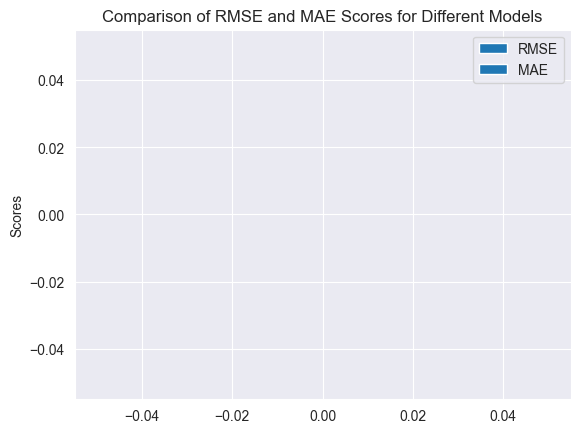

In [109]:
# Initialize dictionaries to store scores
rmse_scores = {}
mae_scores = {}
mse_scores = {}
fcp_scores = {}
precision_scores = {}
recall_scores = {}

k_value = 5  # You can adjust the value of k for precision and recall

for name, model in models.items():
    # Make predictions on the test set
    # Run 5-fold cross-validation and print results.

    cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Create a bar chart to compare RMSE and MAE scores
width = 0.35  # the width of the bars
fig, ax = plt.subplots()

rmse_bars = ax.bar([x for x in rmse_scores.keys()], rmse_scores.values(), width, label='RMSE')
mae_bars = ax.bar([x for x in mae_scores.keys()], mae_scores.values(), width, label='MAE', bottom=list(rmse_scores.values()))

ax.set_ylabel('Scores')
ax.set_title('Comparison of RMSE and MAE Scores for Different Models')
ax.legend()

plt.show()

In [108]:
rmse_scores

{'KNNBasic': 0.956247043351055,
 'KNNWithMeans': 0.9029828877561419,
 'KNNWithZScore': 0.9006590661571038,
 'KNNBaseline': 0.8812775785631012,
 'SVD': 0.8809901462240417,
 'SVDpp': 0.8697772502867229,
 'NMF': 0.928464146762641,
 'CoClustering': 0.9525999263431751}

In [90]:
# Get the list of items not rated by a specific user
user_id = 123
# Get the list of all items in the dataset
N=10
all_items = trainset.all_items()

# Get the list of items rated by the specific user
rated_items_by_user = [item for item, _ in trainset.ur[trainset.to_inner_uid(user_id)]]

# Get the list of items not rated by the user
items_not_rated_by_user = list(set(all_items) - set(rated_items_by_user))

# Make predictions for the items not rated by the user
item_predictions = [model.predict(user_id, item_id) for item_id in items_not_rated_by_user]

# Sort the predictions by estimated rating
sorted_predictions = sorted(item_predictions, key=lambda x: x.est, reverse=True)

# Get the top N recommendations
top_n_recommendations = sorted_predictions[:N]


In [91]:
top_n_recommendations

[Prediction(uid=123, iid=99, r_ui=None, est=5, details={'was_impossible': False}),
 Prediction(uid=123, iid=148, r_ui=None, est=5, details={'was_impossible': False}),
 Prediction(uid=123, iid=187, r_ui=None, est=5, details={'was_impossible': False}),
 Prediction(uid=123, iid=467, r_ui=None, est=5, details={'was_impossible': False}),
 Prediction(uid=123, iid=495, r_ui=None, est=5, details={'was_impossible': False}),
 Prediction(uid=123, iid=506, r_ui=None, est=5, details={'was_impossible': False}),
 Prediction(uid=123, iid=549, r_ui=None, est=5, details={'was_impossible': False}),
 Prediction(uid=123, iid=626, r_ui=None, est=5, details={'was_impossible': False}),
 Prediction(uid=123, iid=633, r_ui=None, est=5, details={'was_impossible': False}),
 Prediction(uid=123, iid=876, r_ui=None, est=5, details={'was_impossible': False})]

# implementing SVD algorithm and evaluating the model

In [92]:
# initialize the model
algo=SVD()

In [103]:
# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8718  0.8733  0.8708  0.8740  0.8706  0.8721  0.0014  
MAE (testset)     0.6707  0.6715  0.6669  0.6701  0.6721  0.6703  0.0018  
Fit time          1.32    0.82    0.79    1.03    0.81    0.96    0.20    
Test time         0.08    0.09    0.08    0.17    0.08    0.10    0.04    


{'test_rmse': array([0.87182627, 0.87329748, 0.87077213, 0.87403724, 0.87056821]),
 'test_mae': array([0.67072795, 0.67147898, 0.66689396, 0.67009537, 0.67208838]),
 'fit_time': (1.318427324295044,
  0.8248550891876221,
  0.7898612022399902,
  1.029221773147583,
  0.8128266334533691),
 'test_time': (0.07822728157043457,
  0.0867912769317627,
  0.07813358306884766,
  0.1701371669769287,
  0.07840752601623535)}

In [94]:
# make prediction
predictions=algo.test(testset)

# evaluating the model using the default parameter
mae=accuracy.mae(predictions)
rmse=accuracy.rmse(predictions)

MAE:  0.6790
RMSE: 0.8828


It seems SVD performed really well as compare to KNNBasic

In [95]:
# Saving the model for later use
model_filename='final_model_svd.pkl'
pickle.dump(algo, open(model_filename, 'wb'))



# Code to recommend movies using the trained modle

In [96]:
# mapping the movie id with tmdb id for movie poster
# merge the linksdf with moviesdf
final_moviedf=moviesdf.merge(linksdf, on='movieId')
final_moviedf.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [97]:
def recommend_movies(model,no_movies, user_id, all_items,movie_mapping):
    # Get the list of items rated by the specific user
    rated_items_by_user = [item for item, _ in trainset.ur[trainset.to_inner_uid(user_id)]]

    # Get the list of items not rated by the user
    items_not_rated_by_user = list(set(all_items) - set(rated_items_by_user))

    # Make predictions for the items not rated by the user
    item_predictions = [model.predict(user_id, item_id) for item_id in items_not_rated_by_user]

    # Sort the predictions by estimated rating
    sorted_predictions = sorted(item_predictions, key=lambda x: x.est, reverse=True)

    # Get the top N recommendations
    top_n_recommendations = sorted_predictions[:no_movies]

    movie_titles=[]
    predicted_ratings=[]
    tmdbIDs=[]

    for recommendation in top_n_recommendations:
        item_id=str(recommendation.iid)
        movie_title=movie_mapping.get(item_id, 'Unknown Movie')
        tmdbID=movie_mapping.get(item_id,'Unknown Movie')
        movie_titles.append(movie_title)
        predicted_ratings.append(recommendation.est)
        tmdbIDs.append(tmdbID)
        print(f"User:{recommendation.uid}  Movie ID:{item_id}  Movie Title: {movie_title}   Predicted rating: {recommendation.est}    TMDBID:{tmdbID}")

    return  movie_titles, predicted_ratings, tmdbIDs

In [98]:
all_items = trainset.all_items()
user_id=123
number_movies=10
movie_mapping = dict(zip(final_moviedf['movieId'].astype(str),final_moviedf['tmdbId']))
movie_title, ratings, tmdbIDs=recommend_movies(model=algo,no_movies= number_movies, user_id=user_id, all_items=all_items, movie_mapping=movie_mapping)

User:123  Movie ID:1172  Movie Title: 11216.0   Predicted rating: 4.650839686830983    TMDBID:11216.0
User:123  Movie ID:318  Movie Title: 278.0   Predicted rating: 4.529386617826802    TMDBID:278.0
User:123  Movie ID:904  Movie Title: 567.0   Predicted rating: 4.515207396734457    TMDBID:567.0
User:123  Movie ID:1252  Movie Title: 829.0   Predicted rating: 4.4711665774643    TMDBID:829.0
User:123  Movie ID:1276  Movie Title: 903.0   Predicted rating: 4.437405379976444    TMDBID:903.0
User:123  Movie ID:1228  Movie Title: 1578.0   Predicted rating: 4.391093712460851    TMDBID:1578.0
User:123  Movie ID:6  Movie Title: 949.0   Predicted rating: 4.388474504313226    TMDBID:949.0
User:123  Movie ID:4226  Movie Title: 77.0   Predicted rating: 4.3864671836664    TMDBID:77.0
User:123  Movie ID:1204  Movie Title: 947.0   Predicted rating: 4.384807771737677    TMDBID:947.0
User:123  Movie ID:2959  Movie Title: 550.0   Predicted rating: 4.384719215607993    TMDBID:550.0


In [99]:
movie_title

[11216.0, 278.0, 567.0, 829.0, 903.0, 1578.0, 949.0, 77.0, 947.0, 550.0]

In [101]:
def recommend_movies_for_user_based_on_movie(user_id, movie_id, top_n=10):
    # Get the top N similar movies for the given movie based on the SVD model
    similar_movies = algo.get_neighbors(movie_id, k=top_n)

    # Filter out movies the user has already watched
    user_watched_movies = set(data.df[data.df['user'] == user_id]['item'])
    recommended_movies = [data.to_raw_iid(movie) for movie in similar_movies if movie not in user_watched_movies][:top_n]

    return recommended_movies

In [102]:
# Example usage:
user_id = 123  # Replace with the actual user ID
movie_id = 456  # Replace with the movie ID input by the user
top_n_recommendations = 5

recommendations = recommend_movies_for_user_based_on_movie(user_id, movie_id, top_n=top_n_recommendations)
print("Top", top_n_recommendations, "recommendations for user based on the movie:", recommendations)

AttributeError: 'SVD' object has no attribute 'sim'

In [131]:
ratingsdf['rating'].count()

100836

In [132]:
user_id=600
selected_user_df=ratingsdf[ratingsdf['userId']==user_id]


In [133]:
selected_user_df['rating'].count()

763